# Introduction. I want to classify any user image by training on availabe satellite image. The training and test data set DeepSat(SAT-4) Airborne Dataset is from https://www.kaggle.com/arpandhatt/satellite-image-classification.

SAT-4

SAT-4 consists of a total of 500,000 image patches covering four broad land cover classes. These include - barren land, trees, grassland and a class that consists of all land cover classes other than the above three. 400,000 patches (comprising of four-fifths of the total dataset) were chosen for training and the remaining 100,000 (one-fifths) were chosen as the testing dataset. We ensured that the training and test datasets belong to disjoint set of image tiles. Each image patch is size normalized to 28x28 pixels. Once generated, both the training and testing datasets were randomized using a pseudo-random number generator.

The MAT file for the SAT-4 dataset contains the following variables:

train_x	28x28x4x400000 uint8 (containing 400000 training samples of 28x28 images each with 4 channels)
train_y	400000x4 uint8 (containing 4x1 vectors having labels for the 400000 training samples)
test_x	28x28x4x100000 uint8 (containing 100000 test samples of 28x28 images each with 4 channels)
test_y	100000x4 uint8 (containing 4x1 vectors having labels for the 100000 test samples)

## Section 1 input data

In [1]:
#import modules
import os
import copy
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from math import ceil
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, LeakyReLU, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import rescale, resize


In [2]:
# read the satellite image csv file. The original file has 400,000 train samples and 100,000 test samples. 
x_train = pd.read_csv("X_train_sat4.csv", header=None)
x_test = pd.read_csv("X_test_sat4.csv", header=None)
y_train = pd.read_csv("y_train_sat4.csv", header=None)
y_test = pd.read_csv("y_test_sat4.csv", header=None)

In [3]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,104,103,94,133,114,115,106,145,104,110,...,95,141,101,103,92,138,103,110,99,148
1,175,149,130,146,169,148,130,141,166,139,...,119,132,137,133,121,134,134,128,119,132
2,113,114,105,163,126,131,125,176,119,125,...,129,177,122,126,113,172,130,136,131,181
3,107,104,100,124,108,105,102,126,105,104,...,74,85,74,70,63,78,83,79,73,92
4,105,100,95,132,77,72,62,114,76,77,...,86,129,106,100,85,128,118,109,99,130


In [4]:
x_train.shape

(400000, 3136)

In [5]:
y_train.shape

(400000, 4)

In [6]:
x_test.shape

(100000, 3136)

In [7]:
y_test.shape

(100000, 4)

## Section 2 EDA

In [8]:
#Convert the training and testing data into numpy array with shape of [image no, 28,28,4]
x_train_img = x_train.to_numpy().reshape([400000,28,28,4])
x_test_img = x_test.to_numpy().reshape([100000,28,28,4])

In [9]:
#convert x from pandas dataframe to numpy array
x_train_np = x_train.to_numpy()
x_test_np = x_test.to_numpy()

In [10]:
#convert label y from pandas dataframe to numpy array
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

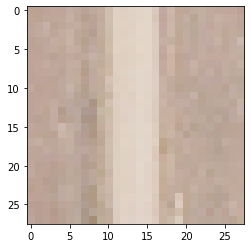

Barren Land


In [11]:
# Examine the image. The color channel are R,G,B, and I(Infrared)
# Type a image number between 0 and 400,000 to check the image.
ix = 10000
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

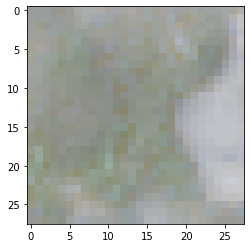

Trees


In [12]:
ix = 5000
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

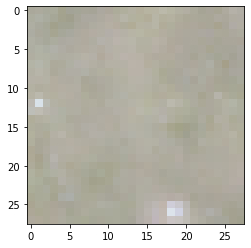

Grassland


In [13]:
ix = 39999
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

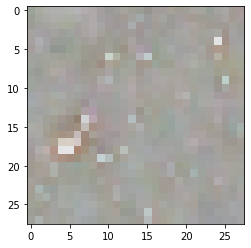

Other


In [14]:
ix = 20000
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

In [15]:
# Check how many images in each class
sum = [0,0,0,0]
for i in range(len(y_train_np)):
    for j in range(4):
        sum[j] = sum[j]+y_train_np[i][j]

print("There are {} barren land, there are {} trees, there are {} grassland, there are {} others".format(sum[0], sum[1], sum[2], sum[3]))

There are 104465 barren land, there are 81118 trees, there are 72017 grassland, there are 142400 others


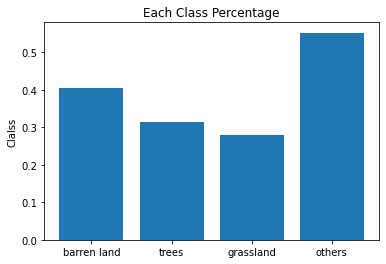

In [16]:
total = 0
for i in range(3):
    total = total + sum[i]
percent = sum / total
objects = ('barren land', 'trees', 'grassland', 'others')
y_pos = np.arange(len(objects))

plt.bar(y_pos, percent, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Clalss')
plt.title('Each Class Percentage')
plt.show()

## Section 3 Model Test

### Section 3.1 Deep neural network
This model is only for education purpose

In [17]:
# Now we normalize data. This means we make the mean 0, and the standard deviation 1 for the best results. However, dividing the image by 255 is good enough. We will just divide the array by 255:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

In [18]:
# Deep neural network model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(3136,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [19]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Train data
r = model.fit(x_train_norm, y_train_np, validation_split=0.2, epochs=10, verbose=0)


Epoch 1/10
10000/10000 [==============================] - 21s 2ms/step - loss: 1.3509 - accuracy: 0.3572 - val_loss: 1.3529 - val_accuracy: 0.3508
Epoch 2/10
10000/10000 [==============================] - 15s 1ms/step - loss: 1.3502 - accuracy: 0.3573 - val_loss: 1.3529 - val_accuracy: 0.3508
Epoch 3/10
10000/10000 [==============================] - 14s 1ms/step - loss: 1.3502 - accuracy: 0.3573 - val_loss: 1.3535 - val_accuracy: 0.3508
Epoch 4/10
10000/10000 [==============================] - 14s 1ms/step - loss: 1.3502 - accuracy: 0.3573 - val_loss: 1.3531 - val_accuracy: 0.3508
Epoch 5/10
10000/10000 [==============================] - 13s 1ms/step - loss: 1.3502 - accuracy: 0.3573 - val_loss: 1.3530 - val_accuracy: 0.3508
Epoch 6/10
10000/10000 [==============================] - 14s 1ms/step - loss: 1.3502 - accuracy: 0.3573 - val_loss: 1.3529 - val_accuracy: 0.3508
Epoch 7/10
10000/10000 [==============================] - 13s 1ms/step - loss: 1.3502 - accuracy: 0.3573 - val_loss: 1

Text(0.5, 1.0, 'Loss of train and validation data in each epoch')

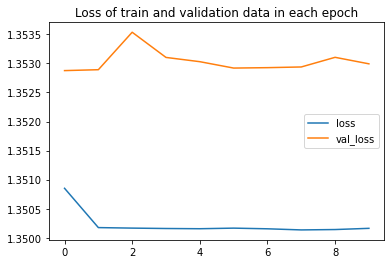

In [21]:
# Plot what's returned by model.fit()
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss of train and validation data in each epoch')

Text(0.5, 1.0, 'Accuracy of train and validation data in each epoch')

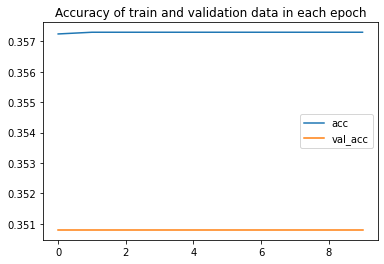

In [22]:
# Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy of train and validation data in each epoch')

In [23]:
# Evaluate the model - evaluate() returns loss and accuracy
print("Train score:", model.evaluate(x_train_norm, y_train_np))
print("Test score:", model.evaluate(x_test_norm, y_test_np))

12500/12500 [==============================] - 9s 759us/step - loss: 1.3507 - accuracy: 0.3560
Train score: [1.3506662845611572, 0.35600000619888306]
3125/3125 [==============================] - 3s 818us/step - loss: 1.3502 - accuracy: 0.3563
Test score: [1.3502219915390015, 0.3563399910926819]


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                31370     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 31,524
Trainable params: 31,524
Non-trainable params: 0
_________________________________________________________________


# This results clearly demonstrate general deep neural network doesn't work on image classification. We will move to other effecive neural network model.

### Section 3.2 Convolution neural network

In [25]:
# Prepare data for cnn model
x_train_img_norm = x_train_img / 255
x_test_img_norm = x_test_img / 255

In [26]:
x_train_img.shape

(400000, 28, 28, 4)

In [27]:
# Build convolution network
cnn_model = Sequential()
cnn_model.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=(28, 28, 4), padding='same'))
cnn_model.add(Dropout(0.25))
#cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(10, kernel_size=3, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

In [28]:
# Compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# Save model parameter in the file "weights.hdf5"
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True)
# Store in a list to be used during training
callbacks_list = [checkpoint]

# Fit the model on a training set, using the checkpoint as a callback
r_cnn = cnn_model.fit(x_train_img_norm, y_train_np, validation_split=0.2, epochs=10, callbacks=callbacks_list, verbose=0)

In [30]:
# Evaluate the model - evaluate() returns loss and accuracy
print("Train score:", cnn_model.evaluate(x_train_img_norm, y_train_np))
print("Test score:", cnn_model.evaluate(x_test_img_norm, y_test_np))

12500/12500 [==============================] - 34s 3ms/step - loss: 0.0959 - accuracy: 0.9672
Train score: [0.09592956304550171, 0.96715247631073]
3125/3125 [==============================] - 9s 3ms/step - loss: 0.1035 - accuracy: 0.9660
Test score: [0.10349529981613159, 0.965969979763031]


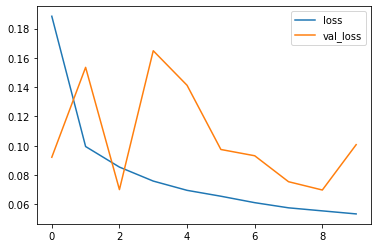

In [31]:
# Plot what's returned by model.fit()
plt.plot(r_cnn.history['loss'], label='loss')
plt.plot(r_cnn.history['val_loss'], label='val_loss')
plt.legend()

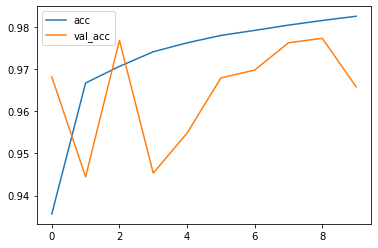

In [32]:
# Plot the accuracy too
plt.plot(r_cnn.history['accuracy'], label='acc')
plt.plot(r_cnn.history['val_accuracy'], label='val_acc')
plt.legend()

In [33]:
# Just use very simple CNN architecture the accuracy can reached to 94%. I am going to add more complexity to the CNN model.
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        370       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 10)        910       
_________________________________________________________________
flatten (Flatten)            (None, 6760)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 27044     
Total params: 28,324
Trainable params: 28,324
Non-trainable params: 0
_________________________________________________________________


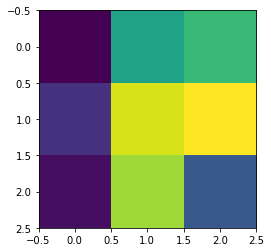

In [34]:
# Interpreting model
# Visulize the kernel
conv1 = cnn_model.layers[0]
weights1 = conv1.get_weights()
kernels1 = weights1[0]
kernel1_1 = kernels1[:,:, 0, 0]
plt.imshow(kernel1_1)
plt.show()

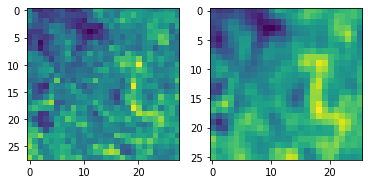

In [35]:
# Check what does the first kernel do to the image
# pick the 4th image in the training set
test_image = x_train_img_norm[4,:,:,0]

# convolve this image with kernel
conv_1 = np.zeros((26,26))
for i in range(26):
    for j in range(26):
        window = test_image[i:i+3, j:j+3]
        conv_1[i,j] = np.sum(window*kernel1_1)

#plt these two images

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(test_image)
ax2.imshow(conv_1)
plt.show()

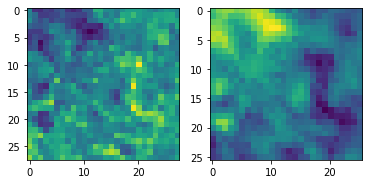

In [36]:
# Check what does the second kernel do to the image
# pick the 4th image in the training set
kernel1_2 = kernels1[:,:, 0, 1]

# convolve this image with kernel
conv_2 = np.zeros((26,26))
for i in range(26):
    for j in range(26):
        window = test_image[i:i+3, j:j+3]
        conv_2[i,j] = np.sum(window*kernel1_2)

#plt these two images

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(test_image)
ax2.imshow(conv_2)
plt.show()

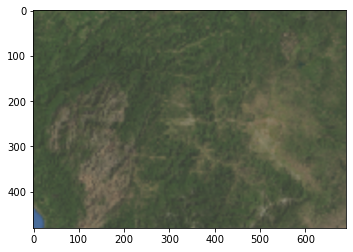

In [37]:
# read test imges
test_img = plt.imread('test_image_gpradar.png')
plt.imshow(test_img)

In [38]:
test_img.shape

(480, 690, 4)

In [39]:
from PIL import Image
img = Image.open('test_image_gpradar.png') # image extension *.png,*.jpg
new_width  = 128
new_height = 128
img = img.resize((new_width, new_height), Image.ANTIALIAS)
img.save('test_image_gpradar_resize.png') 



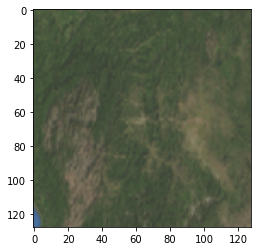

In [40]:
test_img2 = plt.imread('test_image_gpradar_resize.png')
plt.imshow(test_img2)

In [43]:
# Model_prediction
# loading stored parameterd
model.load_weights('weights.hdf5')
model.predict_classes(test_img2)

ValueError: Shapes (3136, 10) and (3, 3, 4, 10) are incompatible

### Section 3.3 GAN model

In [ ]:
# N, H, W, C = x_train_img_norm.shape
# D = H * W * C

In [ ]:
# # Dimensionality of the latent space
# latent_dim = 100

In [ ]:
# # Get the generator model
# def build_generator(latent_dim):
#     i = Input(shape=(latent_dim,))
#     x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
#     x = BatchNormalization(momentum=0.8)(x)
#     x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
#     x = BatchNormalization(momentum=0.8)(x)
#     x = Dense(1024, activation=LeakyReLU(alpha=0.2))(i)
#     x = BatchNormalization(momentum=0.8)(x)
#     x = Dense(D, activation='tanh')(x)
    
#     model = Model(i, x)
#     return model

In [ ]:
# # Get the discriminator model
# def build_discriminator(img_size):
#     i = Input(shape=(img_size,))
#     x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
#     x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
#     x = Dense(1, activation='sigmoid')(x)
#     model = Model(i,x)
#     return model   

In [ ]:
# # Compile both models in preparation for training

# # Build and compile the discriminator
# discriminator = build_discriminator(D)
# discriminator.compile(
#     loss='binary_crossentropy',
#     optimizer=Adam(0.0002, 0.5),
#     metrics=['accuracy'])

# # Build and compile the combined model
# generator = build_generator(latent_dim)

# # Create an input to represent noise sample from latent space
# z = Input(shape=(latent_dim,))

# # Pass noise through generator to get an image
# img = generator(z)

# # Make sure only the generator is trained
# discriminator.trainable = False

# # Take true output is fake, but we label them real!
# fake_pred = discriminator(img)

# # Create the combined model object
# combined_model = Model(z, fake_pred)

# # Compile the combined model
# combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [ ]:
# # Train the GAN

# # Config
# batch_size = 32
# epochs = 1000
# sample_period = 100 # every 'sample_period' steps generate and save some data

# # Create batch labels to use when calling train_on_batch
# ones = np.ones(batch_size)
# zeros = np.zeros(batch_size)

# # Store the losses
# d_losses = []
# g_losses = []

# # Create a folder to store generated images
# if not os.path.exists('gan_images'):
#     os.makedirs('gan_images')

In [ ]:
# # A function to generate a grid of random samples from the generator and save them to a file
# def sample_images(epoch):
#     rows, cols = 5, 5
#     noise = np.random.randn(rows * cols, latent_dim)
#     imgs = generator.predict(noise)
    
#     # Rescale images 0 - 1
#     imgs = 0.5 * imgs + 0.5
    
#     fig, axs = plt.subplots(rows, cols)
#     idx = 0
#     for i in range(rows):
#         for j in range(cols):
#             axs[i,j].imshow(imgs[idx].reshape(H, W, C), cmap='rainbow')
#             axs[i,j].axis('off')
#             idx += 1
#     fig.savefig("gan_images/%d.png" % epoch)
#     plt.close()

In [ ]:
# # Now we normalize data. This means we make the mean 0, and the standard deviation 1 for the best results. However, dividing the image by 255 is good enough. We will just divide the array by 255:
# x_train_np_norm = x_train_np / 255
# x_test_np_norm = x_test_np / 255

In [ ]:
# Main training loop
# for epoch in range(epochs):
#     ## Train discriminator##
    
#     # Select a random batch of images
#     idx = np.random.randint(0, x_train_np_norm.shape[0], batch_size)
#     real_imgs = x_train_np_norm[idx]
   
    
#     # Generate fake images
#     noise = np.random.randn(batch_size, latent_dim)
#     fake_imgs = generator.predict(noise)
    
#     #Train the dsicriminator
#     # both loss and accuracy are returned
#     d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
#     d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
#     d_loss = 0.5 * (d_loss_real + d_loss_fake)
#     d_acc = 0.5 * (d_acc_real  + d_acc_fake)
    
    
#     ## Train generator
#     noise = np.random.randn(batch_size, latent_dim)
#     g_loss = combined_model.train_on_batch(noise, ones)
    
#     # Save the losses
#     d_losses.append(d_loss)
#     g_losses.append(g_loss)
    
#     if epoch % 100 == 0:
#         print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
              
#     if epoch % sample_period == 0:
#         sample_images(epoch)

In [ ]:
# plt.plot(d_losses, label = 'd_loss')
# plt.plot(g_losses, label = 'g_loss')
# plt.legend()
# plt.show()

In [ ]:
# ls gan_images

In [ ]:
# a = imread('gan_images/0.png')
# plt.imshow(a)

In [ ]:
# Save model





## Section 4 Model Prediction